In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mplfinance as mpf

# Preliminaries

(this function is from Chapter 2 solutions to generate volume-base threshold bars)

In [2]:
def calculate_candle_indices(times, qty, threshold):
    indices = [times.iloc[0]]  # Initial timestamp for the first candle
    cumulative_sum = 0
    for time, volume in zip(times, qty):
        cumulative_sum += volume
        if cumulative_sum >= threshold:
            cumulative_sum = 0  # Reset cumulative sum after reaching the threshold
            indices.append(time)  # Add the timestamp of the next transaction as a new boundary
    return indices

def trades_to_ohlc_volume(df_trades, volume_threshold, dollar_vol=False):
    df_trades = df_trades.copy()
    
    # Whether base is volume or dollar volume
    if dollar_vol:
        base = 'quote_qty'
    else:
        base = 'qty'
    
    # Apply function to get timestamps for candle boundaries
    candle_boundaries = calculate_candle_indices(df_trades['time'], df_trades[base], volume_threshold)
    # Use boundaries to determine candle indices
    df_trades['candle_idx'] = np.digitize(df_trades['time'], bins=candle_boundaries) - 1
    
    # Determine start and end timestamps for each candle
    start_times = df_trades.groupby('candle_idx')['time'].min()
    end_times = df_trades.groupby('candle_idx')['time'].max()

    
    df_trades['time'] = pd.to_datetime(df_trades['time'], unit='ms')
    # Create columns for volumes with is_buyer_maker == True and False
    df_trades['qty_buyer_maker'] = np.where(df_trades['is_buyer_maker'], df_trades[base], 0)
    df_trades['qty_non_buyer_maker'] = np.where(~df_trades['is_buyer_maker'], df_trades[base], 0)

    # Group by candle index to calculate OHLCV and duration
    ohlcv = df_trades.groupby('candle_idx').agg(
        Open=('price', 'first'),
        High=('price', 'max'),
        Low=('price', 'min'),
        Close=('price', 'last'),
        Volume_buy=('qty_non_buyer_maker', 'sum'),
        Volume_sell=('qty_buyer_maker', 'sum'),
        OpenTime=('time', 'first'),
        CloseTime=('time', 'last')
    ).reset_index()

    # Calculate the duration of each candle in seconds
    ohlcv['Duration'] = (ohlcv['CloseTime'] - ohlcv['OpenTime']).dt.total_seconds()
    # Drop candle_idx
    ohlcv.drop(columns=['candle_idx'], inplace=True)
    ohlcv.index = ohlcv.OpenTime
    
    return ohlcv

In [3]:
df_trades = pd.read_csv('../data/test_trades_data.zip', compression='zip')
df = trades_to_ohlc_volume(df_trades, 100_000, dollar_vol=True)

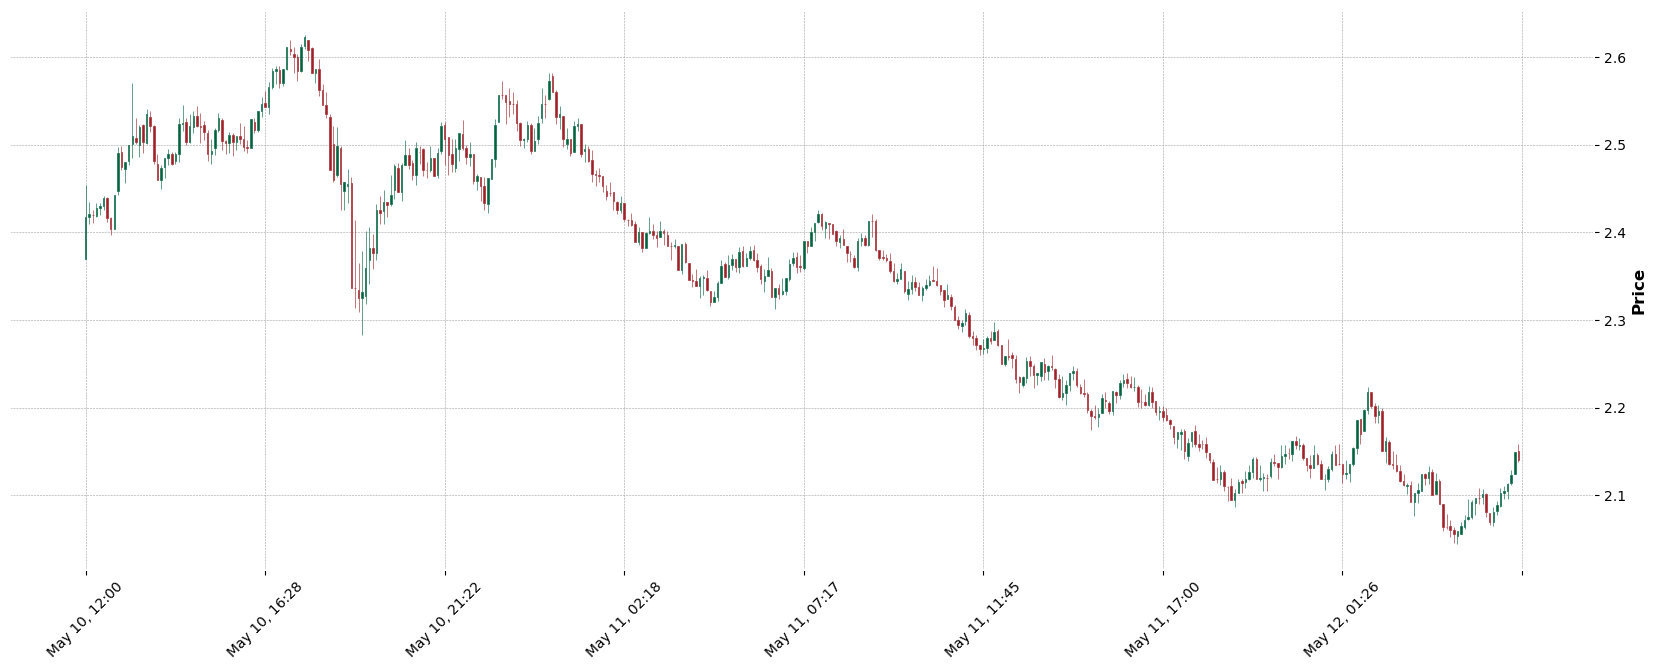

In [4]:
mpf.plot(df[:400], type='candle', style='charles', ylabel='Price', figsize=(22, 8))

# 3.1

### (a) 
Apply a symmetric CUSUM filter (Chapter 2, Section 2.5.2.1) where the threshold is the standard deviation of daily returns (Snippet 3.1).

In [5]:
def getDailyVol(close, span0=100):
    # Function from Snippet 3.1 to calculate daily volatility
    df0 = close.index.searchsorted(close.index - pd.Timedelta(days=1))
    df0 = df0[df0 > 0]
    df0 = pd.Series(close.index[df0 - 1], index=close.index[close.shape[0] - df0.shape[0]:])
    df0 = close.loc[df0.index] / close.loc[df0.values].values - 1  # daily returns
    df0 = df0.ewm(span=span0).std()
    return df0

def getTEvents(gRaw, h):
    # Symmetric CUSUM filter from Snippet 2.4
    tEvents, sPos, sNeg = [], 0, 0
    diff = gRaw.diff()
    for i in diff.index[1:]:
        sPos, sNeg = max(0, sPos + diff.loc[i]), min(0, sNeg + diff.loc[i])
        if sNeg < -h:
            sNeg = 0
            tEvents.append(i)
        elif sPos > h:
            sPos = 0
            tEvents.append(i)
    return pd.DatetimeIndex(tEvents)

# Apply to your data
daily_volatility = getDailyVol(df['Close'])
threshold = daily_volatility.mean() #* 2  # Note that we take 2 std for CUSUM h
cusum_events = getTEvents(df['Close'], threshold)
print(f"Number of CUSUM samples: {len(cusum_events)}")

Number of CUSUM samples: 421


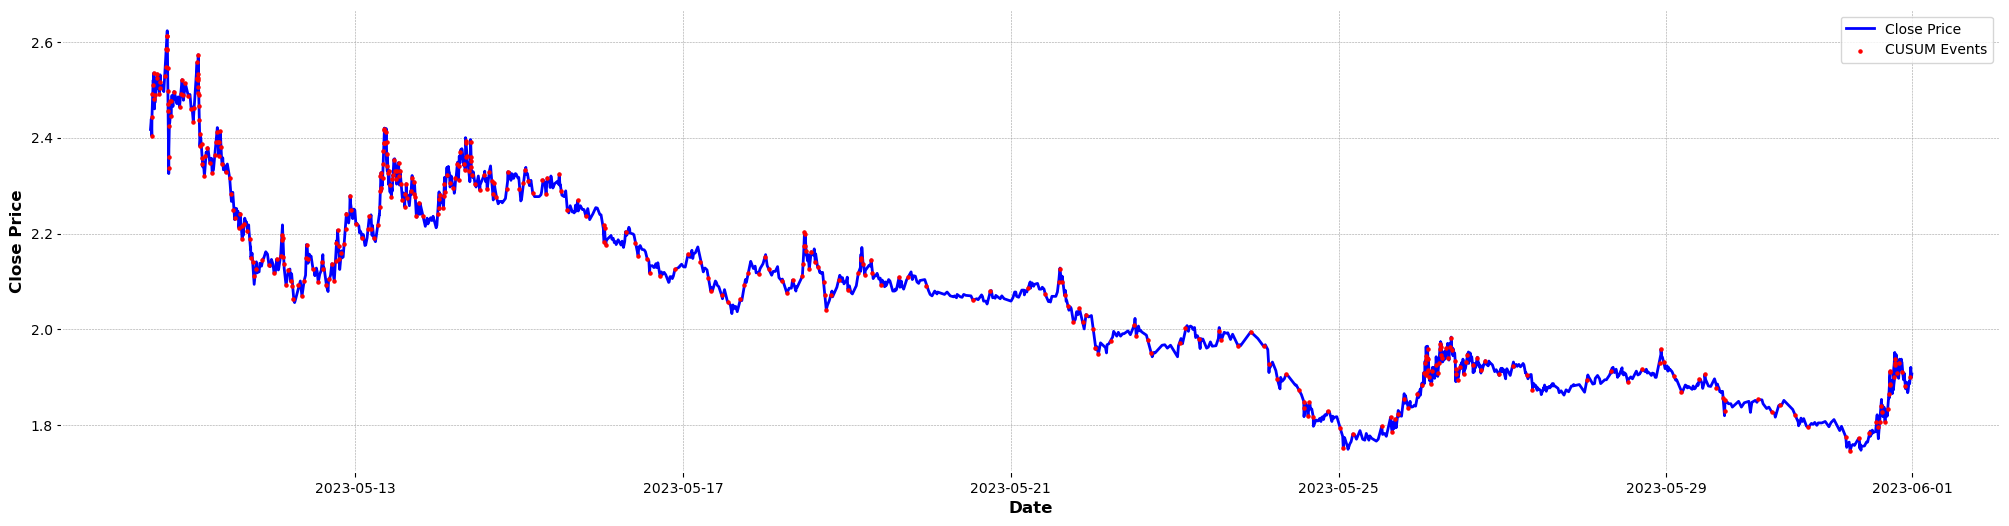

In [6]:
plt.figure(figsize=(25, 6))
plt.plot(df.index, df['Close'], label='Close Price', color='blue')

# Overlay the CUSUM events on the plot
# We use the event timestamps to index into the 'Close' prices for plotting
plt.scatter(cusum_events, df.loc[cusum_events, 'Close'], color='red', 
            marker='o', s=5, label='CUSUM Events', zorder=5)

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

### (b)
Use Snippet 3.4 on a pandas series t1, where numDays=1.

In [7]:
def getVerticalBarrier(close, tEvents, numDays=1):
    # Snippet 3.4
    t1 = close.index.searchsorted(tEvents + pd.Timedelta(days=numDays))
    t1 = t1[t1 < close.shape[0]]
    t1 = pd.Series(close.index[t1], index=tEvents[:t1.shape[0]])  # NaNs at the end
    return t1

t1 = getVerticalBarrier(df['Close'], cusum_events, numDays=1)
t1.shape

(396,)

### (c), (d) 
Apply the triple-barrier method, where ptSl = [1,1] and t1 is the series you created in point (b). Apply getBins to generate the labels.

In [8]:
def getBins(close, events, ptSl):
    """
    Apply the triple-barrier method to label events.
    
    Parameters:
      close: pandas Series of close prices (with datetime index).
      events: DataFrame with columns:
              - 't1': vertical barrier (exit time)
              - 'trgt': target return (typically estimated per event)
      ptSl: list [pt_multiplier, sl_multiplier]
      
    Returns:
      DataFrame 'events' with an added column 'bin':
         +1 if the profit-taking barrier is hit first,
         -1 if the stop-loss barrier is hit first,
         0 if neither barrier is touched before t1.
    """
    out = events.copy()
    out['bin'] = 0  # default label
    
    # Use items() instead of iteritems()
    for loc, barrier_time in out['t1'].items():
        # Get the price series from the event time to the vertical barrier
        price_path = close.loc[loc:barrier_time]
        if price_path.empty:
            continue
        
        # The target return for this event
        trgt = out.at[loc, 'trgt']
        # Define profit-taking and stop-loss thresholds
        init_price = close.loc[loc]
        pt = ptSl[0] * trgt
        sl = -ptSl[1] * trgt
        
        upper_barrier = init_price * (1 + pt)
        lower_barrier = init_price * (1 + sl)
        
        # Find the first time the price touches either barrier
        touched_pt = price_path[price_path >= upper_barrier]
        touched_sl = price_path[price_path <= lower_barrier]
        
        # Determine which barrier was touched first
        if not touched_pt.empty and (touched_sl.empty or touched_pt.index[0] <= touched_sl.index[0]):
            out.at[loc, 'bin'] = 1
        elif not touched_sl.empty and (touched_pt.empty or touched_sl.index[0] < touched_pt.index[0]):
            out.at[loc, 'bin'] = -1
        else:
            out.at[loc, 'bin'] = 0
    return out



In [9]:
std = df['Close'].pct_change().rolling(window=20).std().dropna().reindex(t1.index, method='ffill')

events = pd.DataFrame({
    't1': t1,
    'trgt': 2 * std  
})

labeled_events = getBins(df['Close'], events, ptSl=[1, 1])


Let's plot it 

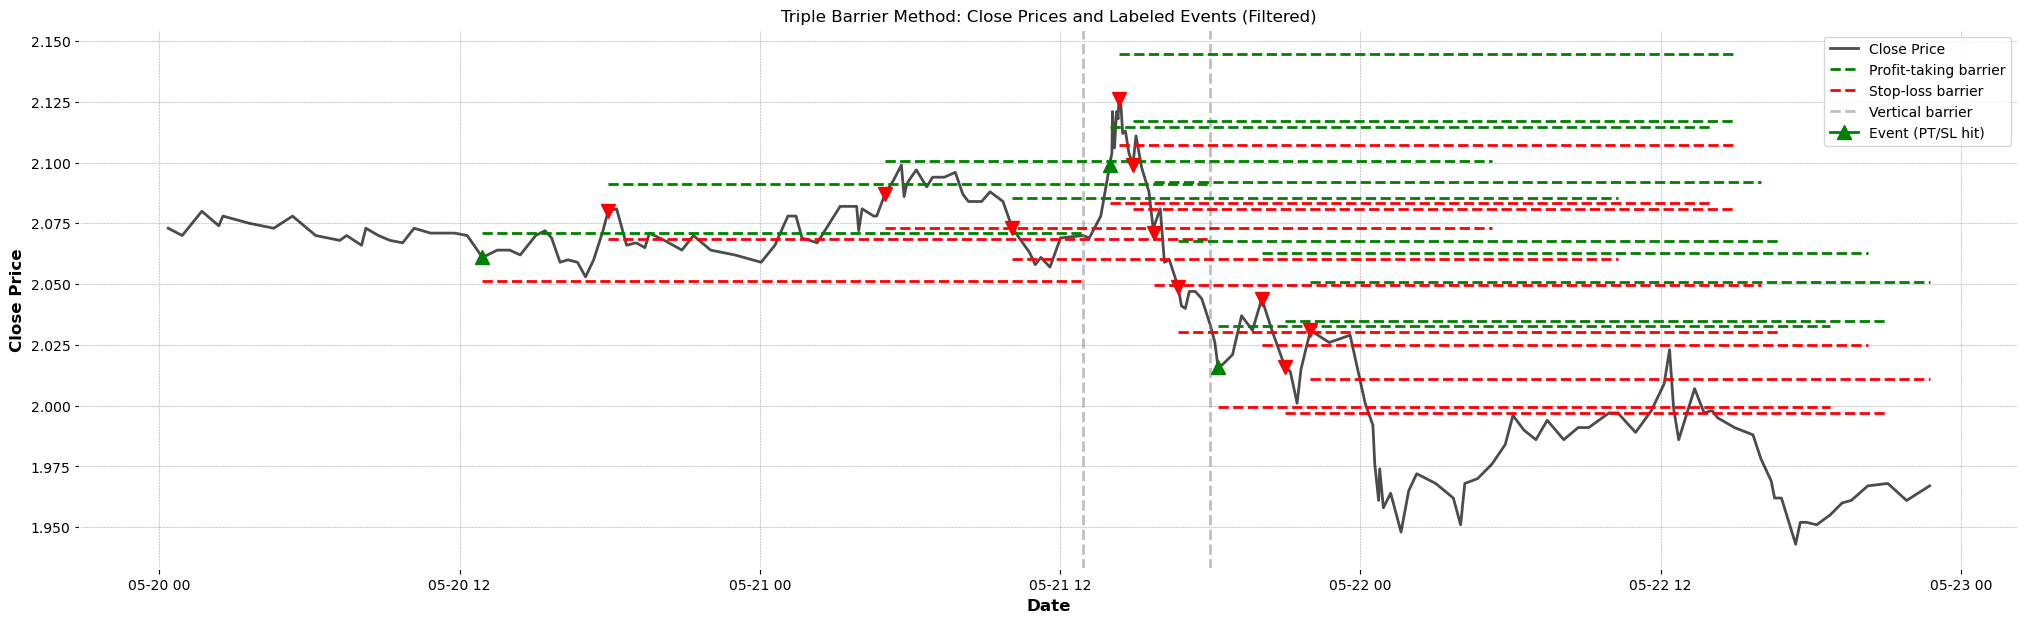

In [10]:
import matplotlib.pyplot as plt

# Define your time window for plotting (adjust these dates as needed)
start_date = '2023-05-20'
end_date = '2023-05-22'

# Subset the main DataFrame for the chosen date range
df_plot = df.loc[start_date:end_date]

# Also, filter the labeled events that fall within the chosen date range
filtered_events = labeled_events.loc[(labeled_events.index >= start_date) & (labeled_events.index <= end_date)]

plt.figure(figsize=(25, 7))
plt.plot(df_plot.index, df_plot['Close'], label='Close Price', color='black', alpha=0.7)

# Loop over each event in the filtered events to plot the triple barriers
for i, (event_time, row) in enumerate(filtered_events.iterrows()):
    t1 = row['t1']
    trgt = row['trgt']
    init_price = df['Close'].loc[event_time]
    
    # Calculate profit-taking and stop-loss levels
    pt_multiplier, sl_multiplier = 1, 1  # same as used in applyPtSlOnT1
    pt_level = init_price * (1 + pt_multiplier * trgt)
    sl_level = init_price * (1 - sl_multiplier * trgt)
    
    # Plot the profit-taking and stop-loss horizontal lines
    plt.hlines(pt_level, event_time, t1, colors='green', linestyles='dashed',
               label='Profit-taking barrier' if i == 0 else "")
    plt.hlines(sl_level, event_time, t1, colors='red', linestyles='dashed',
               label='Stop-loss barrier' if i == 0 else "")
    
    # Plot the vertical barrier if it lies within our plotting window
    if t1 >= pd.to_datetime(start_date) and t1 <= pd.to_datetime(end_date):
        plt.axvline(x=t1, color='gray', linestyle='--', alpha=0.5,
                    label='Vertical barrier' if i == 0 else "")
    
    # Choose marker based on event label
    if row['bin'] == 1:
        marker, color = '^', 'green'
    elif row['bin'] == -1:
        marker, color = 'v', 'red'
    else:
        marker, color = 'o', 'blue'
    
    plt.plot(event_time, init_price, marker=marker, color=color, markersize=10,
             label='Event (PT/SL hit)' if i == 0 else "")

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Triple Barrier Method: Close Prices and Labeled Events (Filtered)')
plt.legend()
plt.grid(True)
plt.show()


# 3.2
From exercise 1, use Snippet 3.8 to drop rare labels.

In [11]:
def dropLabels(events, minPct=0.05):
    """
    Recursively drop events with rare labels from the events DataFrame.
    
    Parameters:
      events: DataFrame with a 'bin' column representing the labels.
      minPct: float, the minimum relative frequency for a label to be retained.
    
    Returns:
      A filtered DataFrame containing only events with labels that appear
      with frequency greater than or equal to minPct, unless only two classes remain.
    """
    while True:
        label_freq = events['bin'].value_counts(normalize=True)
        # Stop if the minimum frequency is above the threshold or if there are fewer than 3 classes
        if label_freq.min() > minPct or label_freq.shape[0] < 3:
            break
        rare_label = label_freq.idxmin()
        print("Dropping label", rare_label, "with frequency", label_freq.min())
        events = events[events['bin'] != rare_label]
    return events

# Use the function on your labeled_events DataFrame
filtered_events = dropLabels(labeled_events, minPct=0.05)


Dropping label 0 with frequency 0.015151515151515152


# 3.3

Done previously

# 3.4

Develop a trend-following strategy based on a popular technical analysis statistic (e.g., crossing moving averages). For each observation, the model suggests a side, but not a size of the bet.

(a) Derive meta-labels for ptSl = [1,2] and t1 where numDays = 1. Use as trgt the daily standard deviation as computed by Snippet 3.1.

(b) Train a random forest to decide whether to trade or not. Note: The decision is whether to trade or not, {0,1}, since the underlying model (the crossing moving average) has decided the side, {−1,1}.

In [12]:
# Compute a short- and long-term moving average.
short_ma = df['Close'].rolling(window=50).mean()
long_ma = df['Close'].rolling(window=200).mean()

# Create a side signal: 1 if short MA is above long MA, else -1.
side = pd.Series(np.where(short_ma > long_ma, 1, -1), index=df.index)

# Align the side signal with the events (assume events are indexed by the event start).
# Here we extract the side at the event times.
side_at_events = side.reindex(labeled_events.index, method='ffill')

# Compute the meta-label: trade (1) if the product is positive, else 0.
meta_labels = (side_at_events * labeled_events['bin'] > 0).astype(int)

# Add the meta-labels to the labeled_events DataFrame.
labeled_events['meta_label'] = meta_labels

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Features
X = pd.DataFrame({
    'return': df['Close'].pct_change(),
    'short_ma': short_ma,
    'long_ma': long_ma,
    'volatility': daily_volatility
}).dropna()

# We'll reindex the meta_labels to match the dates in X
y = meta_labels.reindex(X.index).fillna(0).astype(int)

# Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train 
clf = RandomForestClassifier(n_estimators=100, random_state=1)
clf.fit(X_train, y_train)

# Predict and evaluate 
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       888
           1       0.29      0.08      0.13        49

    accuracy                           0.94       937
   macro avg       0.62      0.54      0.55       937
weighted avg       0.92      0.94      0.93       937



# 3.5

Develop a mean-reverting strategy based on Bollinger bands. For each observation, the model suggests a side, but not a size of the bet.

### (a) 
Derive meta-labels for ptSl = [0,2] and t1 where numDays = 1. Use as trgt the daily standard deviation as computed by Snippet 3.1.

In [29]:
# Compute daily volatility as the target return estimate
daily_volatility = getDailyVol(df['Close'], span0=100)

# Compute vertical barrier times using numDays = 1
t1 = getVerticalBarrier(df['Close'], cusum_events, numDays=1)

# Reindex the daily volatility to match the event times and scale it as needed
trgt = daily_volatility.reindex(t1.index, method='ffill')
events = pd.DataFrame({'t1': t1, 'trgt': trgt * 0.5})

# Apply the triple-barrier method to label even
labeled_events = getBins(df['Close'], events, ptSl=[1, 1])

Next, let's compute Bollinger bands to generate the underlying “side” signal. For mean reversion, when the price touches the upper band we take a short position (–1), and when it touches the lower band we take a long position (+1).

In [35]:
# Parameters
window = 20
k = 2

# Compute Bollinger bands
middle_band = df['Close'].rolling(window=window).mean()
std_band = df['Close'].rolling(window=window).std()
upper_band = middle_band + k * std_band
lower_band = middle_band - k * std_band

# 1) No trades when price is within the bands.
# 2) Short (side = -1) if price > upper_band
# 3) Long (side = +1) if price < lower_band

side = pd.Series(0, index=df.index, dtype=int)   # Default: 0 = no trade
side[df['Close'] > upper_band] = -1              # Price above upper band -> short
side[df['Close'] < lower_band] = 1               # Price below lower band -> long


In [36]:
# Align the underlying side with the event start times.
side_at_events = side.reindex(labeled_events.index, fill_value=0)

# Derive meta-labels: trade (1) if the product is positive; otherwise 0.
meta_labels = ((side_at_events * labeled_events['bin']) > 0).astype(int)
labeled_events['meta_label'] = meta_labels


#### Some plots

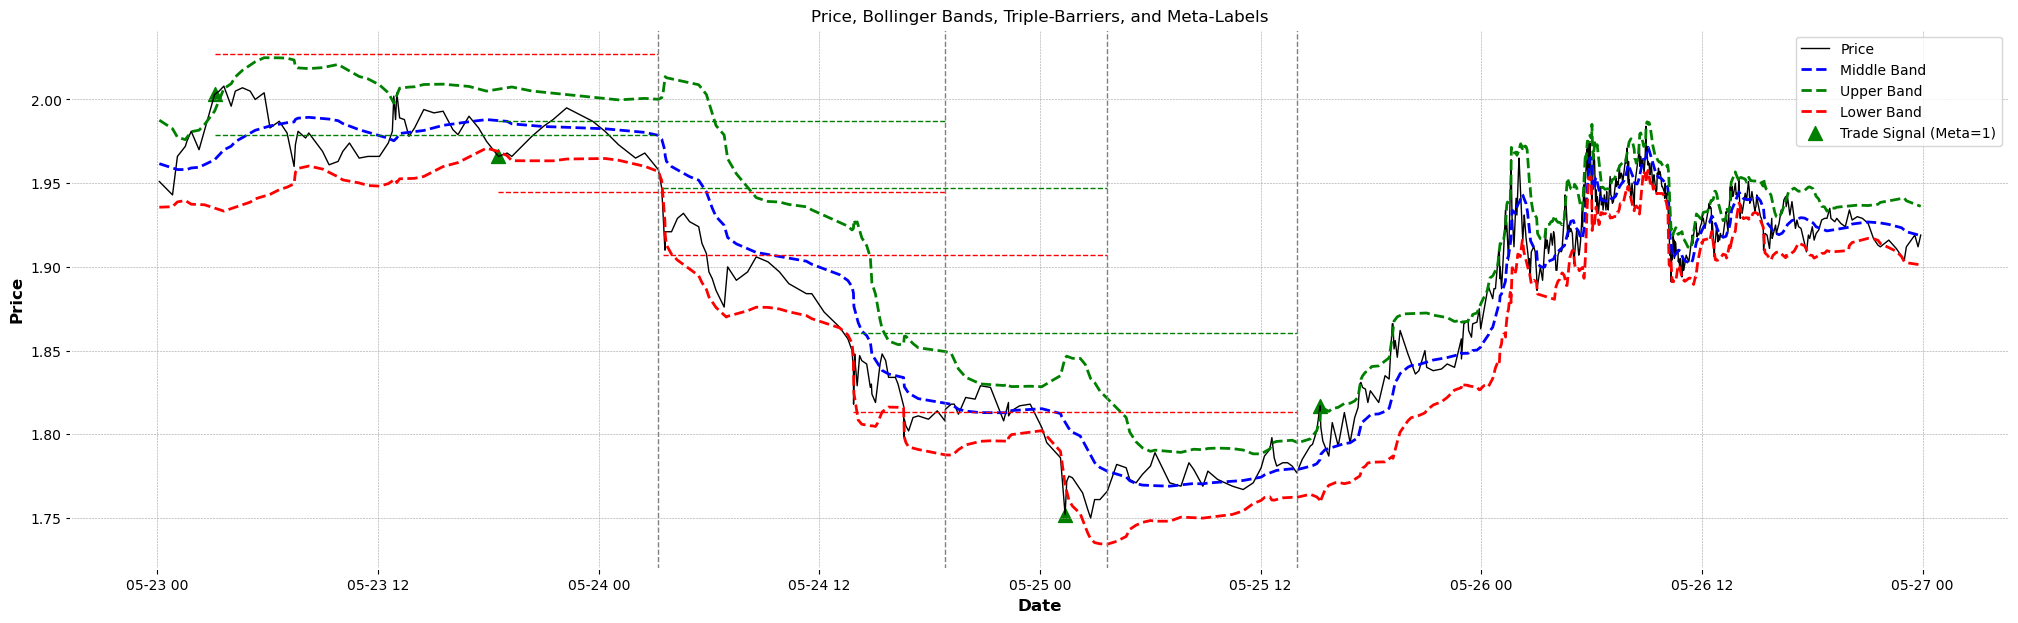

In [39]:
# Choose a date window
start_date = '2023-05-23'
end_date   = '2023-05-26'

# Filter your main price DataFrame and Bollinger bands
df_plot           = df.loc[start_date:end_date]
middle_band_plot  = middle_band.loc[start_date:end_date]
upper_band_plot   = upper_band.loc[start_date:end_date]
lower_band_plot   = lower_band.loc[start_date:end_date]

# Filter the labeled events to the date window
labeled_events_plot = labeled_events.loc[
    (labeled_events.index >= start_date) &
    (labeled_events.index <= end_date)
]

# Prepare the figure
plt.figure(figsize=(25, 7))
plt.plot(df_plot.index, df_plot['Close'], label="Price", color="black", linewidth=1)
plt.plot(df_plot.index, middle_band_plot, label="Middle Band", color="blue",  linestyle="--")
plt.plot(df_plot.index, upper_band_plot,  label="Upper Band",  color="green", linestyle="--")
plt.plot(df_plot.index, lower_band_plot,  label="Lower Band",  color="red",   linestyle="--")

# side_at_events: the side (–1, +1) reindexed to event times
side_at_events = side.reindex(labeled_events.index, method='ffill')

# Separate events by meta-label (optional)
trade_events   = labeled_events_plot[labeled_events_plot['meta_label'] == 1]
no_trade_events = labeled_events_plot[labeled_events_plot['meta_label'] == 0]

# Plot event markers at the event start times
plt.scatter(trade_events.index, df_plot['Close'].reindex(trade_events.index), 
            marker='^', color='green', s=100, label="Trade Signal (Meta=1)")
#plt.scatter(no_trade_events.index, df_plot['Close'].reindex(no_trade_events.index), 
#            marker='v', color='red',   s=100, label="No Trade Signal (Meta=0)")

###############################################################################
# PLOT THE TRIPLE BARRIERS
###############################################################################
start_dt = pd.to_datetime(start_date)
end_dt   = pd.to_datetime(end_date)

for event_time, row in labeled_events_plot.iterrows():
    barrier_time = row['t1']
    if pd.isnull(barrier_time):
        continue
    
    # Now compare barrier_time (Timestamp) with start_dt and end_dt (Timestamps)
    if barrier_time < start_dt or barrier_time > end_dt:
        continue

    # Initial price at event start
    init_price = df['Close'].loc[event_time]
    # The target return volatility scale
    trgt = row['trgt']
    # The side at the event
    side_ = side_at_events.loc[event_time] if event_time in side_at_events.index else 0

    # Compute profit-taking and stop-loss barriers depending on side
    if side_ == 1:  # long
        upper_barrier = init_price * (1 + pt_multiplier * trgt)
        lower_barrier = init_price * (1 - sl_multiplier * trgt)
    elif side_ == -1:  # short
        upper_barrier = init_price * (1 - sl_multiplier * trgt)
        lower_barrier = init_price * (1 + pt_multiplier * trgt)
    else:
        # If side is 0 or not recognized, skip plotting barriers
        continue

    # Plot horizontal dashed lines from event_time -> barrier_time
    # (Profit-taking in green, stop-loss in red)
    plt.hlines(upper_barrier, xmin=event_time, xmax=barrier_time, colors='green',
               linestyles='dashed', linewidth=1, label=None)
    plt.hlines(lower_barrier, xmin=event_time, xmax=barrier_time, colors='red',
               linestyles='dashed', linewidth=1, label=None)

    # Plot a vertical dashed line at barrier_time
    plt.axvline(x=barrier_time, color='gray', linestyle='--', linewidth=1, label=None)

###############################################################################

plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Price, Bollinger Bands, Triple-Barriers, and Meta-Labels")
plt.legend()
plt.grid(True)
plt.show()


### (b) 

Train a random forest to decide whether to trade or not. Use as features: volatility, serial correlation, and the crossing moving averages from
exercise 2.

In [43]:
# Features: volatility, serial correlation, and crossing moving averages
volatility = getDailyVol(df['Close'], span0=100)
returns = df['Close'].pct_change()
serial_corr = returns.rolling(window=20).apply(lambda x: x.autocorr(), raw=False)
short_ma = df['Close'].rolling(window=50).mean()
long_ma = df['Close'].rolling(window=200).mean()
cross_ma = pd.Series(np.where(short_ma > long_ma, 1, -1), index=df.index)

# Create a DataFrame with features
features = pd.DataFrame({
    'volatility': volatility,
    'serial_corr': serial_corr,
    'cross_ma': cross_ma
})

# Align features with the events (labeled_events contains meta_labels)
X = features.reindex(labeled_events.index, method='ffill')

# Target: meta_labels
y = labeled_events['meta_label']

# Remove any rows with missing values
X = X.dropna()
y = y.loc[X.index]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Train the Random Forest classifier (secondary model)
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

# Predict on the test set and evaluate performance
y_pred = clf.predict(X_test)
print("Secondary Model Performance (Random Forest with filtering):")
print(classification_report(y_test, y_pred))

Secondary Model Performance (Random Forest with filtering):
              precision    recall  f1-score   support

           0       0.83      0.91      0.87        80
           1       0.22      0.12      0.15        17

    accuracy                           0.77        97
   macro avg       0.53      0.52      0.51        97
weighted avg       0.72      0.77      0.74        97

